## Initialize notebook

In [49]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt 
import xlrd
from sklearn import cluster, mixture, metrics
import seaborn

%matplotlib inline

## Load data

In [88]:
df1 = pd.read_excel('GAS_E85_GHG_rev2.xlsx', sheetname='Data 6.16.15')
df2 = pd.read_excel('GHG hackathon_fy14_fast_data_extract_081315.xlsx', sheetname='FAST_2014 Vehicles')

df1['AVG_Utilization'] = df1['GGE_PER_VEH_E85']/df1['GGE_PER_VEH_GASE85']

In [89]:
df1.head()

,agyID,agyAbbrev,agyName,GGE_E85,GGE_GAS,GGE_GASE85,GGE_OTHER,GGE_TOTAL,GHG_E85,GHG_GAS,...,GGE_PER_VEH_GASE85,GGE_PER_VEH_OTHER,GGE_PER_VEH_TOTAL,GHG_PER_VEH_E85,GHG_PER_VEH_GAS,GHG_PER_VEH_GASE85,GHG_PER_VEH_OTHER,GHG_PER_VEH_TOTAL,AVG Utilization,AVG_Utilization
0,9,ARMY,Department of Army,1894616,22528664,24423280,5804257,30227537,3513717.593670,1.995879e+08,...,516.687046,573.883429,526.768154,148.540165,8452.100759,4296.719307,4592.140568,4347.133633,0.155014,0.155014
1,13067,BBG,Broadcasting Board of Governors,68,3959,4027,157,4184,126.111463,3.507392e+04,...,143.821429,39.250000,130.750000,25.222293,1524.952978,1257.143927,316.581948,1139.467167,0.094562,0.094562
2,406,CPSC,Consumer Product Safety Commission,1044,20886,21930,245,22175,1936.181874,1.850351e+05,...,243.666667,245.000000,243.681319,56.946526,3304.197767,2077.458409,1976.116621,2075.769717,0.126016,0.126016
3,60392,CSOSA,Court Services and Offender Supervision Agency,1929,8990,10919,5,10924,3577.485484,7.964499e+04,...,143.671053,NaN,143.736842,275.191191,1264.206238,1095.032612,NaN,1094.291034,1.032808,1.032808
4,7,DA,Defense Agencies,91301,1477275,1568576,350347,1918923,169325.039967,1.308760e+07,...,335.955451,431.461823,350.104543,68.002024,6006.243082,2839.350764,3461.262911,2930.650948,0.109143,0.109143


## Visualize data

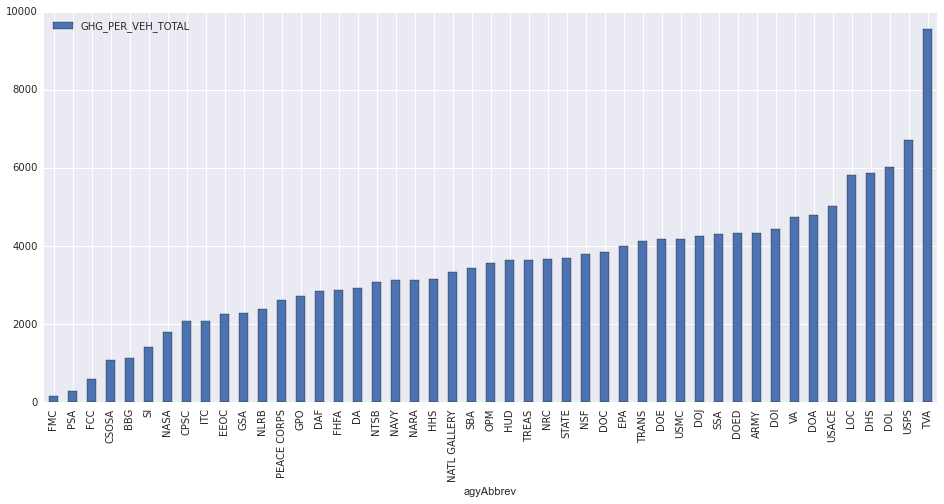

In [125]:
df1_sorted = df1.sort('GHG_PER_VEH_TOTAL')
df1_sorted.plot(x='agyAbbrev',y='GHG_PER_VEH_TOTAL',kind='bar',figsize=[16,7],)

## Clustering by agency

In [90]:
df_cluster = df1[['agyID', 'agyAbbrev', 'agyName', 'VEHCNT_TOTAL', 'GHG_PER_VEH_GASE85', 'GHG_PER_VEH_OTHER', 'GHG_PER_VEH_TOTAL','AVG_Utilization']]
df_cluster = df_cluster.fillna(value=0)

In [114]:
X_train = df_cluster[['VEHCNT_TOTAL','GHG_PER_VEH_TOTAL','AVG_Utilization']]

In [34]:
def normalize_data(df):
  return df.apply(lambda x: (x - np.mean(x))/np.max([np.std(x),1e-10]))

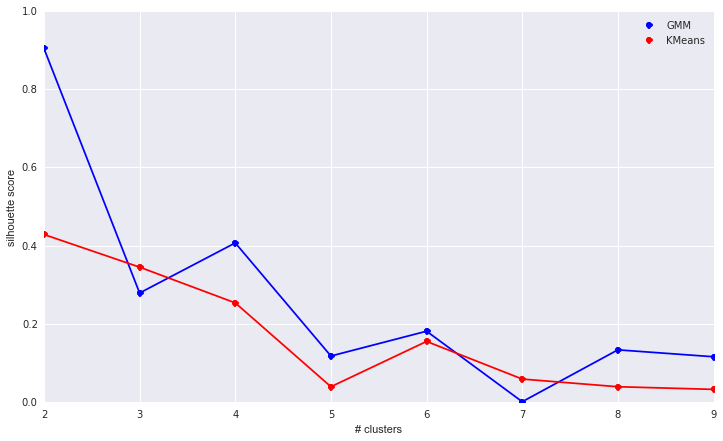

In [115]:
num_c_vec = range(2,10)  # vector of the number of clusters
gmm_perf = []  # initialize GMM performance
kmeans_perf = []  # initialize KMeans performance
for num_c in num_c_vec:  
  gmm_clf = mixture.GMM(n_components=num_c, random_state=42).fit(X_train)
  kmeans_clf = cluster.KMeans(n_clusters=num_c, random_state=42).fit(normalize_data(X_train))

  y_pred_gmm = gmm_clf.predict(X_train)
  y_pred_kmeans = kmeans_clf.predict(normalize_data(X_train))
  
  gmm_perf.append(np.abs(metrics.silhouette_score(X_train, y_pred_gmm, metric='euclidean')))
  kmeans_perf.append(np.abs(metrics.silhouette_score(X_train, y_pred_kmeans, metric='euclidean')))

plt.figure(figsize=[12,7])
plt.plot(num_c_vec, gmm_perf, 'bo')
plt.plot(num_c_vec, kmeans_perf, 'ro')
plt.plot(num_c_vec, gmm_perf, 'b')
plt.plot(num_c_vec, kmeans_perf, 'r')
plt.xlabel('# clusters')
plt.ylabel('silhouette score')
plt.legend(['GMM', 'KMeans'])
plt.show()

In [116]:
num_c = 3

# GMM
clf = mixture.GMM(n_components=num_c, random_state=42).fit(X_train)
y_pred = clf.predict(X_train)

# KMeans
# clf = cluster.KMeans(n_clusters=num_c, random_state=42).fit(normalize_data(X_train))
# y_pred = clf.predict(normalize_data(X_train))

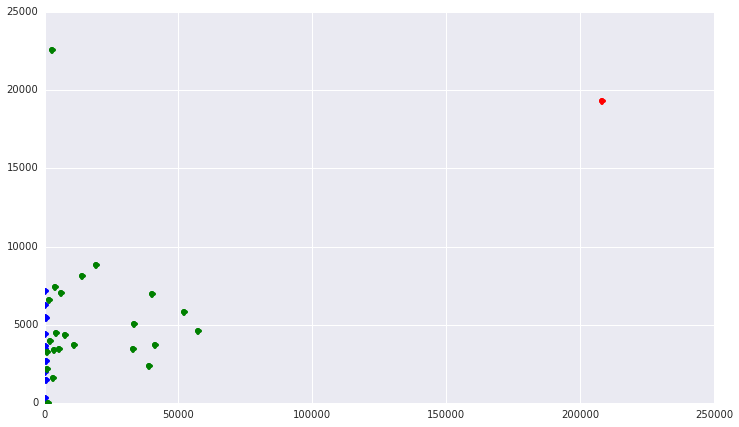

In [117]:
line_vec = ['bo','ro','go','ko','mo','co','yo']

idx = []
for ii in range(num_c):
  idx.append(np.where(y_pred == ii))

plt.figure(figsize=[12,7])
for ii in range(num_c):
  plt.plot(df_cluster['VEHCNT_TOTAL'][idx[ii][0]], df_cluster['GHG_PER_VEH_OTHER'][idx[ii][0]], line_vec[ii])
# plt.xlabel('avg utilization')
# plt.ylabel('GHG (gas + E85) per vehicle')

## Boxplot based on fuel type

In [62]:
df_box = df1[['GHG_PER_VEH_E85','GHG_PER_VEH_GAS','GHG_PER_VEH_GASE85','GHG_PER_VEH_OTHER']]

([<matplotlib.axis.XTick at 0x118e17ad0>,
 <a list of 4 Text xticklabel objects>)

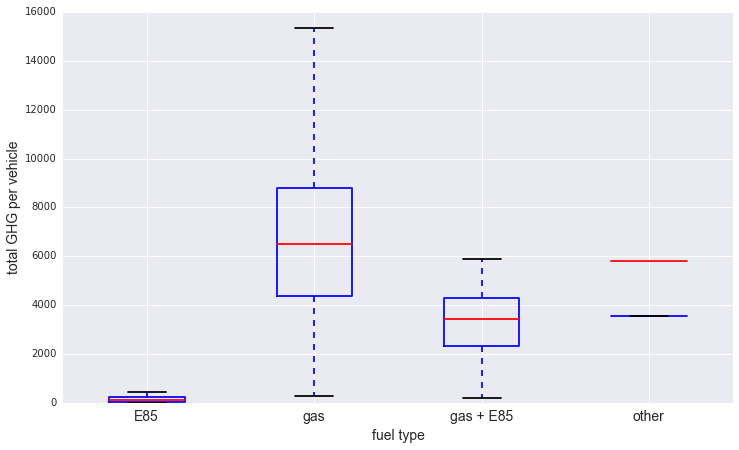

In [68]:
fontsize = 14

plt.figure(figsize=[12,7])
plt.boxplot(np.array(df_box), showfliers=False)
# plt.plot(range(1,25),current_data,'go',label='current day')
plt.xlabel('fuel type', fontsize=fontsize)
plt.ylabel('total GHG per vehicle', fontsize=fontsize)
plt.xticks(range(1,5), ['E85', 'gas', 'gas + E85', 'other'], fontsize=fontsize)
# plt.yticks(fontsize=fontsize)
# plt.legend(fontsize=fontsize, frameon=True, shadow=True, loc='upper left')